# MIS 583 Assignment 4: Self-supervised and transfer learning on CIFAR10

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 鄔仁迪, B104020009.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
# import os
# datadir = "C:/Users/eddie/GitHub/Deep-Learning/PyTorch/Class/pytorch104"
# if not os.path.exists(datadir):
#  !ln -s "/content/drive/My Drive/Your/A4/path/" $datadir # TODO: Fill your A3 path
# os.chdir(datadir)
# !pwd

# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img        #                           
    #######################################################################
    angles = {0: 0, 1: 90, 2: 180, 3: 270}
    if rot in angles:
        return transforms.functional.rotate(img, angles[rot])
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CIFAR10Rotation(root='data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


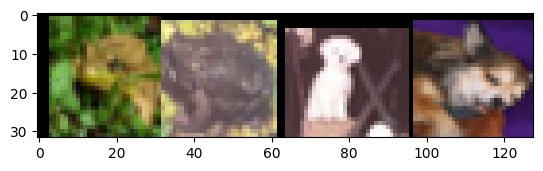

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  frog  frog  dog   dog  


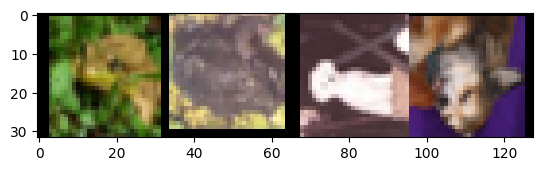

Rotation labels:  0     180   90    270  


In [32]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [33]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            # Calculate outputs by running images through the network
            outputs = net(images)

            # The class with the highest score is what we choose as our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [34]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Notice: You should not use pretrained weights from ImageNet.

In [38]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)

In [39]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [44]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #  
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            # Set data to the correct device
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get predicted results for accuracy calculation
            _, predicted = torch.max(outputs.data, 1)
            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        # Evaluate the model after each epoch
        net.eval()
        run_test(net, testloader, criterion, task)
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################  

    print('Finished Training')

In [45]:
from datetime import datetime

train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #  
################################
# Get current date and time
current_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Save the model
model_path = f"model_{current_time}.pth"
torch.save(net.state_dict(), model_path)
################################
#      End of your code        #  
################################

[1,   100] loss: 1.098 acc: 56.41 time: 8.39
[1,   200] loss: 1.085 acc: 57.01 time: 8.80
[1,   300] loss: 1.081 acc: 58.02 time: 9.22
TESTING:
Accuracy of the network on the 10000 test images: 58.36 %
Average loss on the 10000 test images: 1.072
[2,   100] loss: 1.058 acc: 59.49 time: 7.70
[2,   200] loss: 1.049 acc: 60.07 time: 7.99
[2,   300] loss: 1.047 acc: 59.55 time: 8.07
TESTING:
Accuracy of the network on the 10000 test images: 62.01 %
Average loss on the 10000 test images: 1.011
[3,   100] loss: 1.029 acc: 61.00 time: 8.20
[3,   200] loss: 1.017 acc: 61.88 time: 8.63
[3,   300] loss: 1.022 acc: 61.95 time: 8.72
TESTING:
Accuracy of the network on the 10000 test images: 62.54 %
Average loss on the 10000 test images: 1.018
[4,   100] loss: 1.012 acc: 62.79 time: 9.12
[4,   200] loss: 0.998 acc: 63.11 time: 10.51
[4,   300] loss: 1.008 acc: 62.76 time: 9.68
TESTING:
Accuracy of the network on the 10000 test images: 64.89 %
Average loss on the 10000 test images: 0.986
[5,   100] 

## Fine-tuning on the pre-trained model (9 points)

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################

####################################################
#                End of your code                  #   
####################################################

In [ ]:
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################

#################################################################################################
#                                          End of your code                                     #
#################################################################################################

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = None
optimizer = None

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


## Fine-tuning on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################

#################################################
#              End of your code                 #
#################################################

In [ ]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################

#################################################################################################
#                                          End of your code                                     #
#################################################################################################


In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = None
optimizer = None

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

## Supervised training on the pre-trained model (9 points)
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################

#####################################################
#                End of your code                   #   
#####################################################

In [ ]:
# TODO: Define criterion and optimizer
criterion = None
optimizer = None

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

## Supervised training on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
...
#################################################
#              End of your code                 #
#################################################

In [ ]:
# TODO: Define criterion and optimizer
criterion = None
optimizer = None

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A4.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫就希望大家可以透過去調整不同的訓練方法、損失函數、優化器，或者是調整凍結不同的層來進行這次的實驗，就請大家將嘗試的結果寫在report裡，祝大家順利！

- Rotation task (13 points)
- Fine-tuning the specified layers of the pre-trained model (12 points)
- Fine-tuning the whole pre-trained model (12 points)

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

- In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.
- Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
- If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).
